In [1]:
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import numpy as np
import sigpy as sp
import sigpy.plot as pl
from cmcrameri import cm

from dipy.segment.mask import median_otsu
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
import numpy as np
import nrrd
import scikit_posthocs as sp


import sys
sys.path.append("/home/ahannum/Documents/Phase/cDTI_python")
from mystic_mrpy.Data_Import.Diffusion   import *
from mystic_mrpy.Data_Sorting.Diffusion  import *
from mystic_mrpy.Diffusion.DWI  import *
from mystic_mrpy.Diffusion.Gibbs         import *
from mystic_mrpy.Diffusion.Registration  import *
from mystic_mrpy.Diffusion.Rejection     import *
from mystic_mrpy.Diffusion.Respiratory   import *
from mystic_mrpy.Diffusion.Averaging     import *
from mystic_mrpy.Diffusion.Denoising     import *
from mystic_mrpy.Diffusion.Interpolation import *
from mystic_mrpy.Diffusion.Segmentation_Matrix_DTI import *
from mystic_mrpy.Diffusion.DTI import *
from mystic_mrpy.Diffusion.cDTI import *
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat

import seaborn as sns
sns.set(style='darkgrid', palette='Set2')

In [2]:
import scipy.stats as st

In [3]:
boostrap_m0 = np.zeros((128,128,6,4,10))
boostrap_m1 = np.zeros((128,128,6,4,10))
boostrap_m2 = np.zeros((128,128,6,4,10))


for vv in range(10):

    volunteers=[1,2,3,4,5,7,8,9,10,11]
    volunteer = str(volunteers[vv])
    inpath = '/home/ahannum/Documents/Phase/Data/V00' + volunteer 

    savename = os.path.join(inpath,'M0_std_boostrap_analysis.npz')
    boostrap_m0[:,:,:,:,vv] = np.load(savename)['med']

    savename = os.path.join(inpath,'M1_std_boostrap_analysis.npz')
    boostrap_m1[:,:,:,:,vv] = np.load(savename)['med']

    savename = os.path.join(inpath,'M2_std_boostrap_analysis.npz')
    boostrap_m2[:,:,:,:,vv] = np.load(savename)['med']




In [4]:
## TD Std
volunteers=[1,2,3,4,5,7,8,9,10,11]

td_m0 = np.zeros((128,128,6,4,8,10)) #[lb ub, #volunteers, #slices,TD]
td_m1 = np.zeros((128,128,6,4,8,10)) #[lb ub, #volunteers, #slices,TD]
td_m2 = np.zeros((128,128,6,4,8,10)) #[lb ub, #volunteers, #slices,TD]


M0_mask = np.zeros((128,128,6,4,5,8,10)) #[lb ub, #volunteers, #slices,TD]
M1_mask = np.zeros((128,128,6,4,5,8,10)) #[lb ub, #volunteers, #slices,TD]
M2_mask = np.zeros((128,128,6,4,5,8,10)) #[lb ub, #volunteers, #slices,TD]

for vv in range(10):
    # For each volunteer 
    M0_mag = np.zeros((128,128,6,4,5,8))
    M1_mag = np.zeros((128,128,6,4,5,8))
    M2_mag = np.zeros((128,128,6,4,5,8))

    M0_phs = np.zeros((128,128,6,4,5,8))
    M1_phs = np.zeros((128,128,6,4,5,8))
    M2_phs = np.zeros((128,128,6,4,5,8))


    volunteer = str(volunteers[vv])
    print(volunteer, end = ' ')
    inpath = '/home/ahannum/Documents/Phase/Data/V00' + volunteer 
    name = inpath.split('/')
    namejoin = '/'.join(name[:-1])

    num = 0
    for num in range(3):
        nii_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.nii')]
        bval_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvals')]
        bvec_files   = [_ for _ in os.listdir(inpath) if _.endswith('registered.bvecs')]
        mask_files   = [_ for _ in os.listdir(inpath) if _.endswith('new.nrrd')]
        

        nii_files.sort()
        bval_files.sort()
        bvec_files.sort()
        mask_files.sort()
        
        data,affine, voxsize = load_nifti(os.path.join(inpath, nii_files[num]), return_voxsize=True)
        bvals = np.loadtxt(os.path.join(inpath,bval_files[num])) 
        bvecs = np.loadtxt(os.path.join(inpath,bvec_files[num]))
        mask,header =  nrrd.read(os.path.join(inpath, mask_files[num]))
        
        mask = mask.astype('float')
        mask[mask==0] = np.nan
        
        
        data1,bvals_sort,bvecs_sort = stacked2sorted(data,bvals,bvecs.T)
        
        ims = np.stack((data1[:,:,:,:,:5],data1[:,:,:,:,5:10],data1[:,:,:,:,10:15],
                            data1[:,:,:,:,15:20],data1[:,:,:,:,20:25],data1[:,:,:,:,25:30],
                            data1[:,:,:,:,30:35],data1[:,:,:,:,35:40]),axis = -1)  
            
        
        mag = abs(ims)
        phs = np.angle(ims)
        mask_rep = np.tile(mask[:,:,:,np.newaxis,np.newaxis,np.newaxis],(1,1,1,ims.shape[3],ims.shape[4],ims.shape[5]))
        mask_rep[mask_rep ==0] = np.nan
        
        if num == 0:
            M0_mag[:,:,:,:,:,:] = mag #* mask_rep
            M0_phs[:,:,:,:,:,:,] = phs #*mask_rep
            M0_mask[:,:,:,:,:,:,vv] = mask_rep #*mask_rep
            
        if num == 1:
            M1_mag[:,:,:,:,:,:,] = mag #* mask_rep
            M1_phs[:,:,:,:,:,:] = phs #*mask_rep
            M1_mask[:,:,:,:,:,:,vv] = mask_rep #*mask_rep
            
        if num == 2:
            M2_mag[:,:,:,:,:,:] = mag #* mask_rep
            M2_phs[:,:,:,:,:,:] = phs #*mask_rep
            M2_mask[:,:,:,:,:,:,vv] = mask_rep #*mask_rep

    # NOT divide by the average 
    M0_adj = (np.exp(1j*M0_phs))/np.nanmean(np.exp(1j*M0_phs[:,:,:,0,:,:]),axis = -2)[:,:,:,np.newaxis,np.newaxis,:]
    M1_adj = (np.exp(1j*M1_phs))/np.nanmean(np.exp(1j*M1_phs[:,:,:,0,:,:]),axis = -2)[:,:,:,np.newaxis,np.newaxis,:]
    M2_adj = (np.exp(1j*M2_phs))/np.nanmean(np.exp(1j*M2_phs[:,:,:,0,:,:]),axis = -2)[:,:,:,np.newaxis,np.newaxis,:]

    M0_diff = M0_adj / np.tile(np.nanmean(M0_adj,axis = -2)[:,:,:,:,np.newaxis,:],(1,1,1,1,5,1))
    M1_diff = M1_adj / np.tile(np.nanmean(M1_adj,axis = -2)[:,:,:,:,np.newaxis,:],(1,1,1,1,5,1))
    M2_diff= M2_adj / np.tile(np.nanmean(M2_adj,axis = -2)[:,:,:,:,np.newaxis,:],(1,1,1,1,5,1))

    M0_std = np.sqrt(np.sum(np.angle(M0_diff)**2,axis = -2)/5)
    M1_std = np.sqrt(np.sum(np.angle(M1_diff)**2,axis = -2)/5)
    M2_std= np.sqrt(np.sum(np.angle(M2_diff)**2,axis = -2)/5)

    td_m0[:,:,:,:,:,vv] = M0_std *M0_mask[:,:,:,:,0,:,vv] 
    td_m1[:,:,:,:,:,vv] = M1_std *M1_mask[:,:,:,:,0,:,vv] 
    td_m2[:,:,:,:,:,vv] = M2_std *M2_mask[:,:,:,:,0,:,vv] 

1 2 3 4 5 7 8 9 10 11 

In [5]:
nii_files

['M0_registered.nii', 'M1_registered.nii', 'M2_registered.nii']

In [6]:
td_m0_mean = np.nanmean(td_m0, axis = (0,1))
td_m1_mean = np.nanmean(td_m1, axis = (0,1))
td_m2_mean = np.nanmean(td_m2, axis = (0,1))

td_m0_std = np.nanstd(td_m0, axis = (0,1))
td_m1_std = np.nanstd(td_m1, axis = (0,1))
td_m2_std = np.nanstd(td_m2, axis = (0,1))


std_td_all = np.stack((td_m0_mean,td_m1_mean,td_m2_mean),axis = -1)
std_td_std_all = np.stack((td_m0_std,td_m1_std ,td_m2_std ),axis = -1)

std_td_mean = np.nanmean(std_td_all,axis = -2)
std_std_mean = np.nanmean(std_td_std_all,axis = -2)


bootstrap_m0_mean = np.nanmean(boostrap_m0, axis = (0,1))
bootstrap_m1_mean = np.nanmean(boostrap_m1, axis = (0,1))
bootstrap_m2_mean = np.nanmean(boostrap_m2, axis = (0,1))

bootstrap_m0_std = np.nanstd(boostrap_m0, axis = (0,1))
bootstrap_m1_std = np.nanstd(boostrap_m1, axis = (0,1))
bootstrap_m2_std = np.nanstd(boostrap_m2, axis = (0,1))


std_bootstrap_all = np.stack((bootstrap_m0_mean,bootstrap_m1_mean,bootstrap_m2_mean),axis = -1)
std_bootstrap_std_all = np.stack((bootstrap_m0_std,bootstrap_m1_std ,bootstrap_m2_std ),axis = -1)

std_bootstrap_mean = np.nanmean(std_bootstrap_all,axis = -2)
std_bootstrap_mean = np.nanmean(std_bootstrap_std_all,axis = -2)

print(std_bootstrap_mean.shape)

(6, 4, 3)


In [7]:
td_m0.shape

(128, 128, 6, 4, 8, 10)

In [8]:
import pandas as pd

1.298423419458734


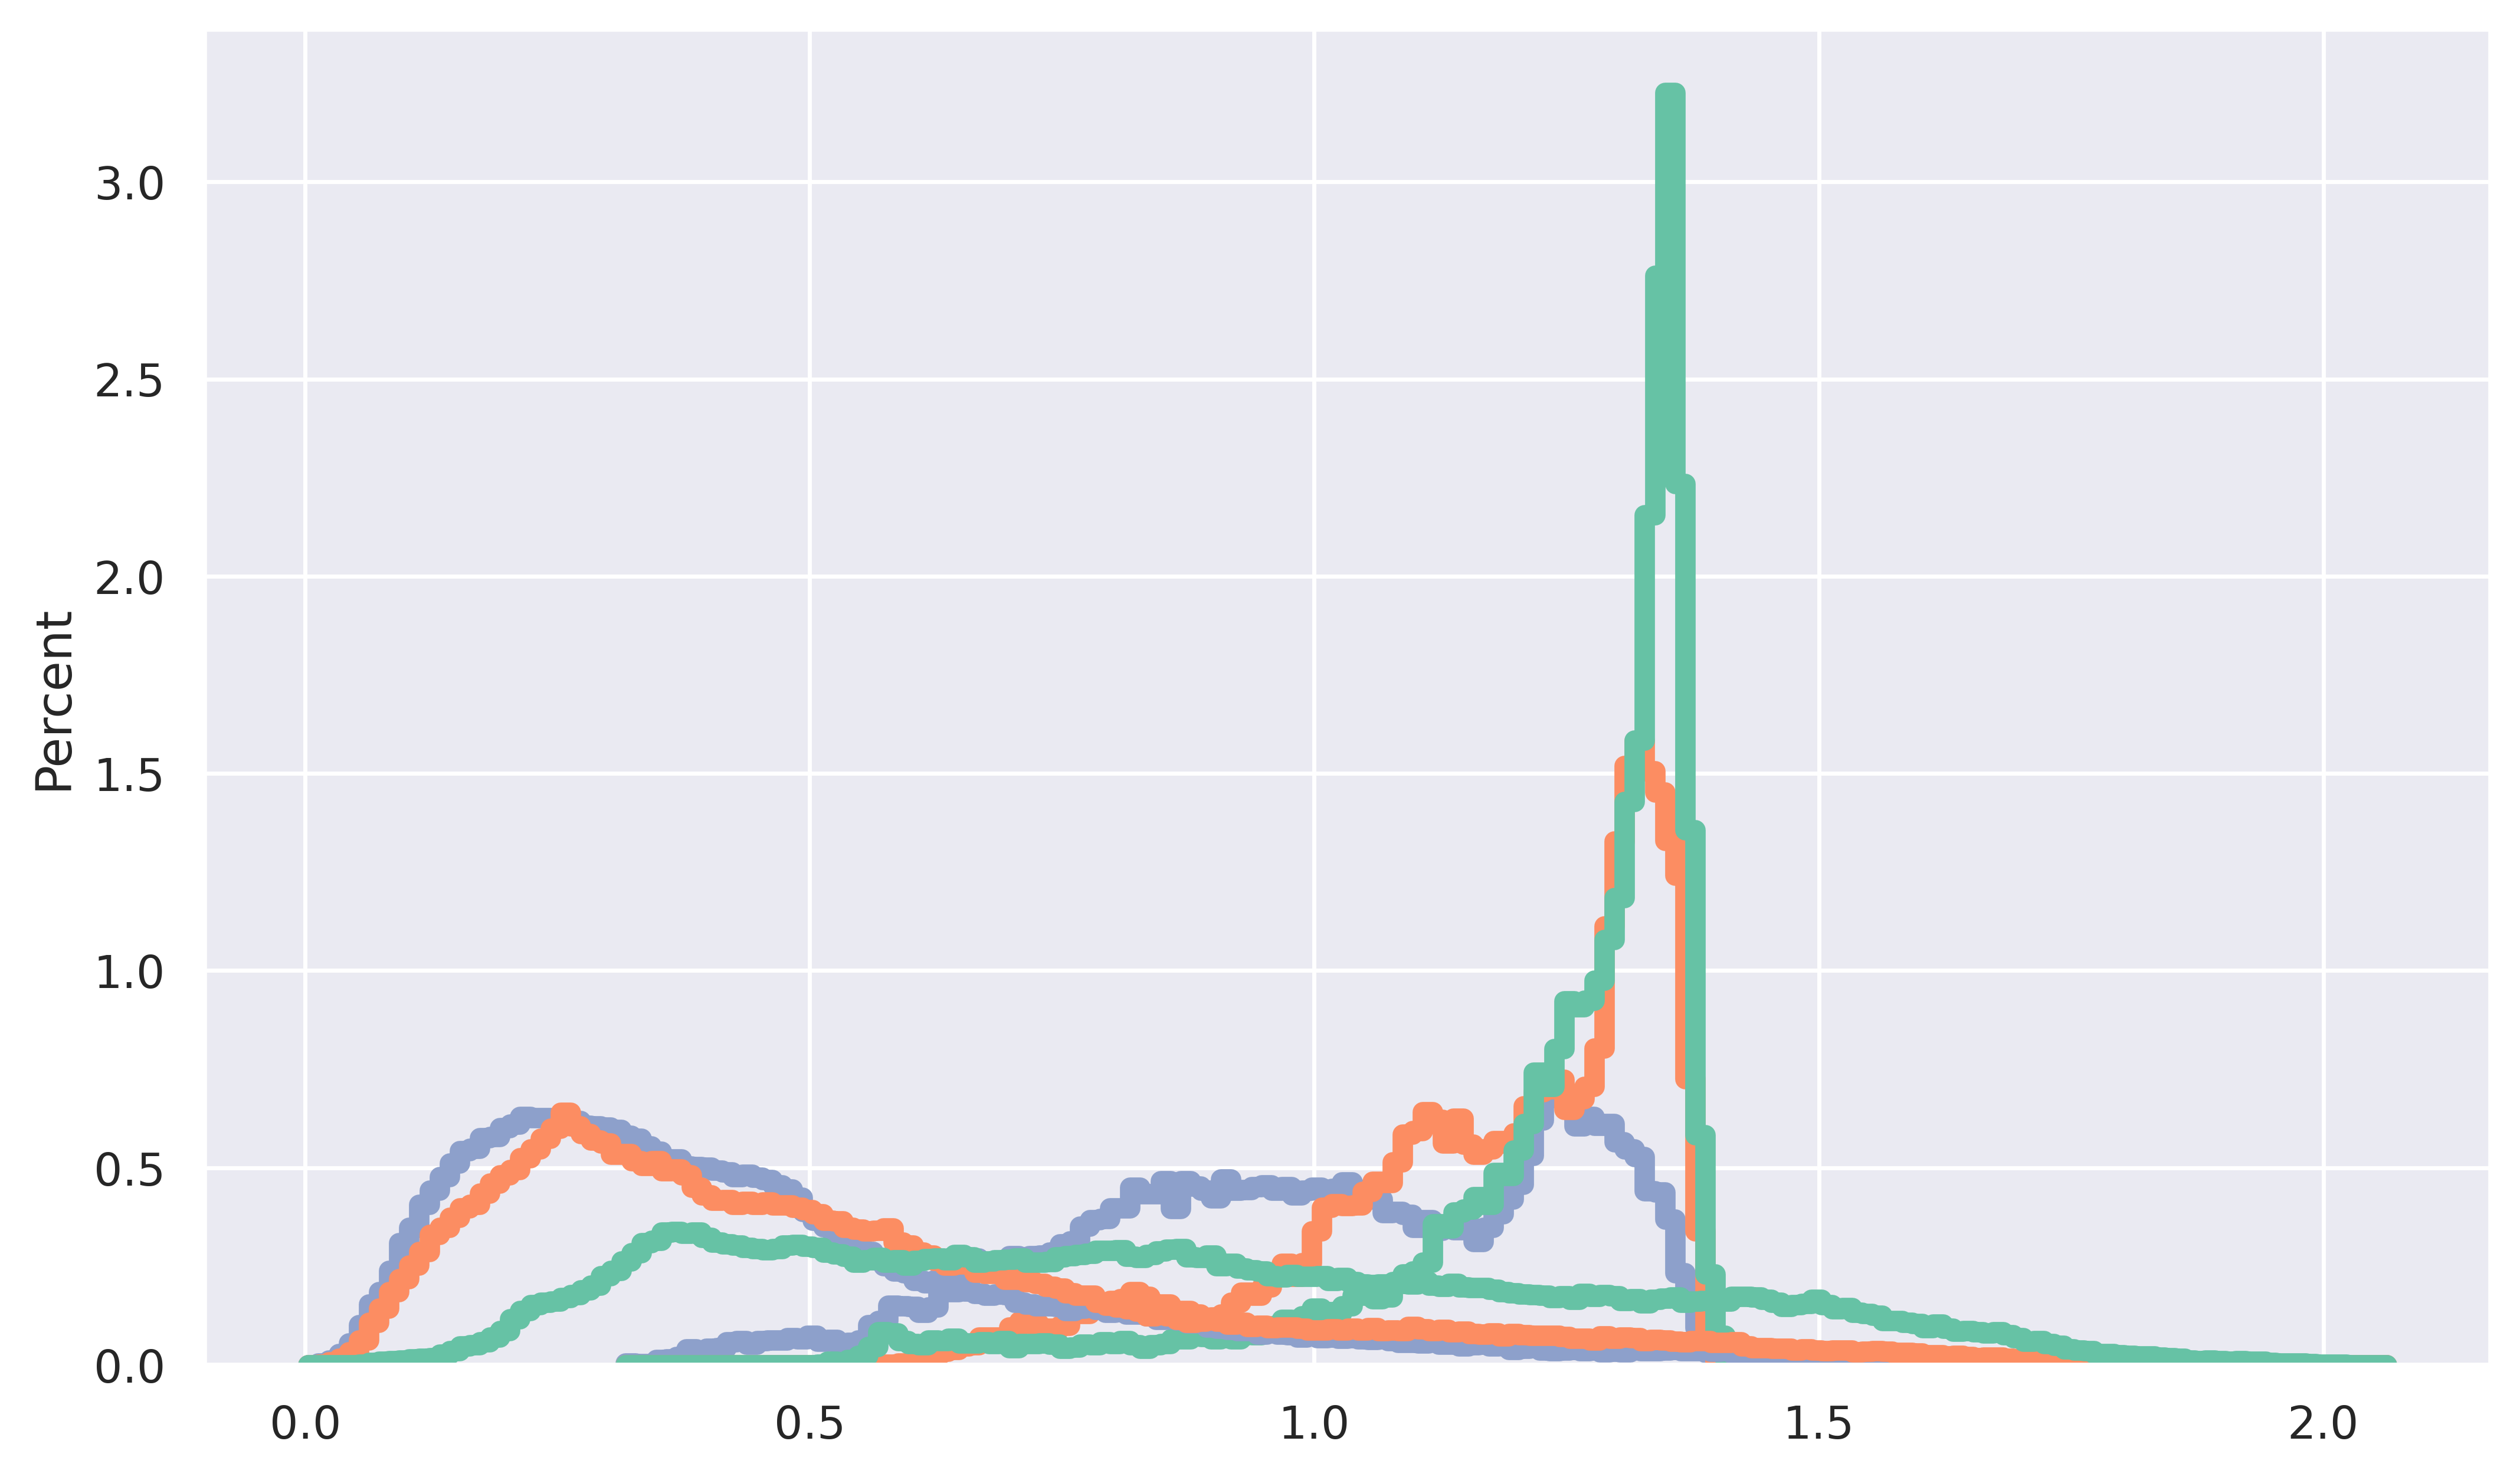

In [9]:
dd = -1
for sl in range(3,4):
    fig, axes = plt.subplots(1, 1, figsize=(10,6),sharex=True,sharey = True,dpi=500)
    med0 = boostrap_m0[:,:,sl,dd,:].reshape((128*128*10))
    med1 = boostrap_m1[:,:,sl,dd,:].reshape((128*128*10))
    med2 = boostrap_m2[:,:,sl,dd,:].reshape((128*128*10))

    print(np.nanmedian(med0))
    med = np.stack((med0,med1,med2),axis = -1)
    data = pd.DataFrame(med)
    count = 0
    slices = [0,1,2]
    sns.histplot(data=data,palette = "Set2",fill =None,stat = 'percent',
        element="step",binwidth = 0.01,  ax = axes,
        kde=False,legend = False,linewidth = 5)


    med0 =td_m0[:,:,sl,dd,:,:].reshape((128*128*8*10))
    med1 = td_m1[:,:,sl,dd,:,:].reshape((128*128*8*10))
    med2 = td_m2[:,:,sl,dd,:,:].reshape((128*128*8*10))
    med = np.stack((med0,med1,med2),axis = -1)
    data = pd.DataFrame(med)
    sns.histplot(data=data,palette = "Set2",fill =None,stat = 'percent',
        element="step",binwidth = 0.01,  ax = axes,
        kde=False,legend = False,linewidth = 5)

    plt.show()





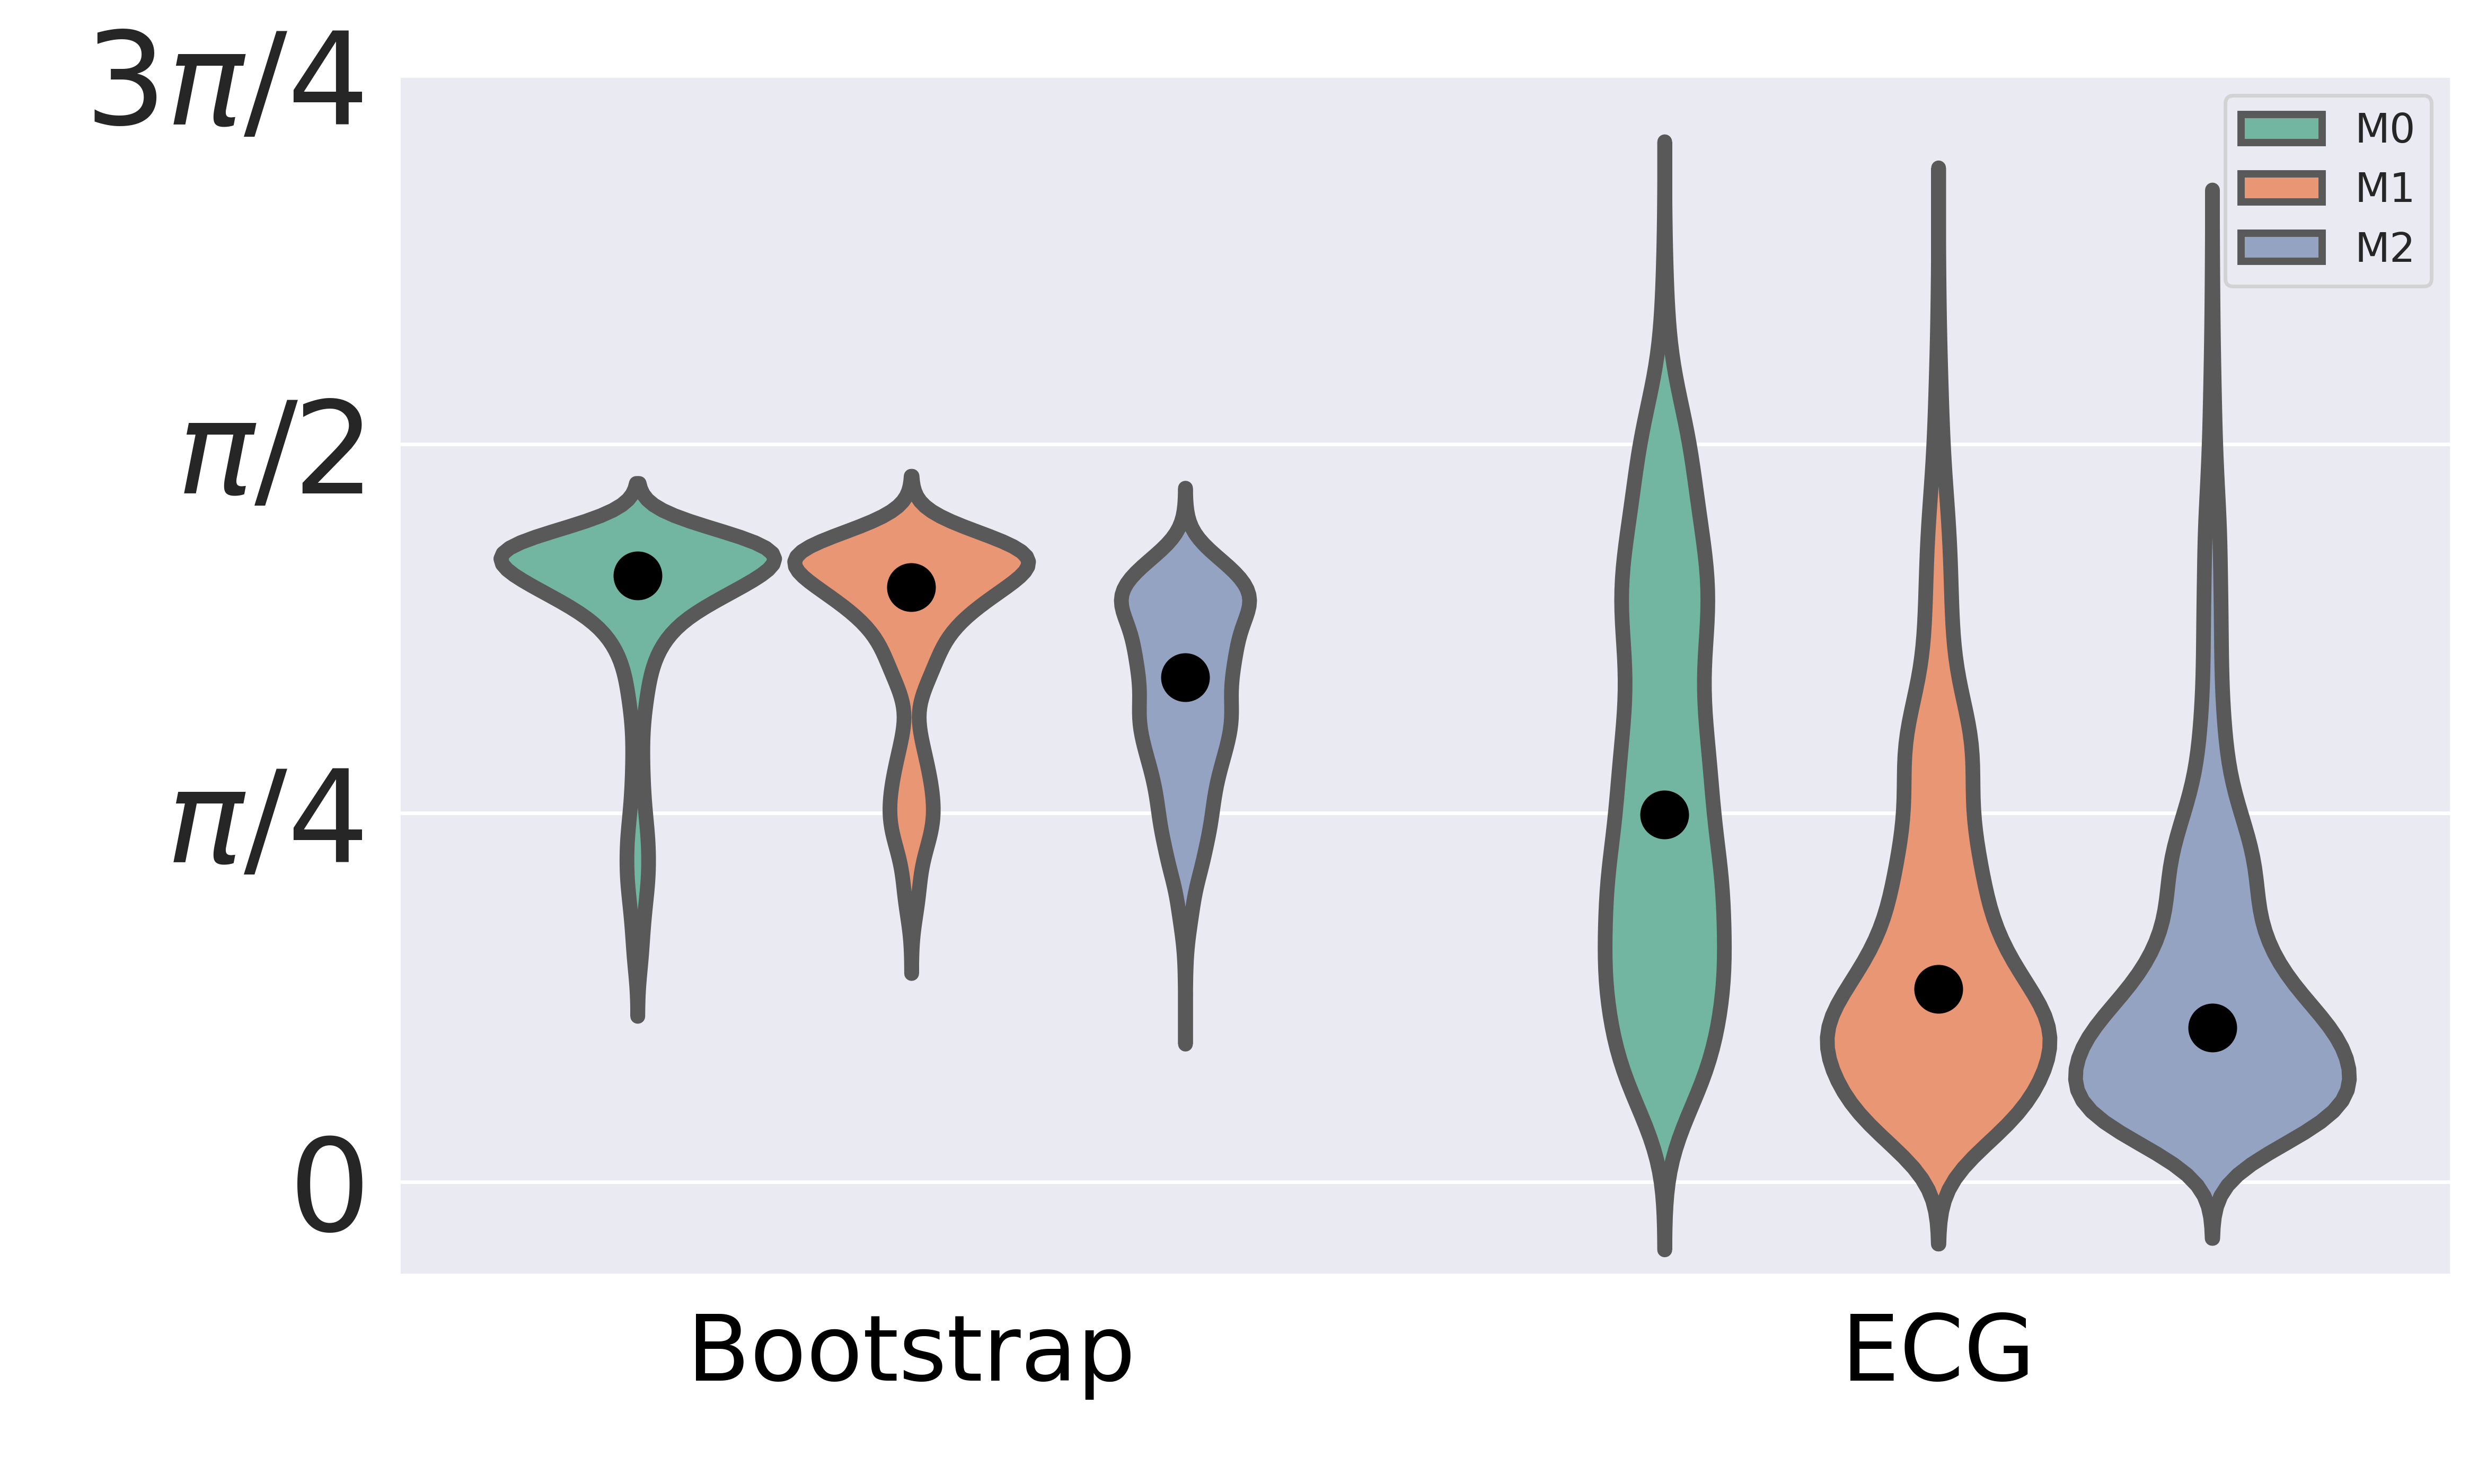

In [10]:
dd = -1
sl = -1


med0 = boostrap_m0[:,:,sl,dd,:].reshape((128*128*10))
med1 = boostrap_m1[:,:,sl,dd,:].reshape((128*128*10))
med2 = boostrap_m2[:,:,sl,dd,:].reshape((128*128*10))

boostrap = np.append(med0,(med1,med2))
motion_b = np.repeat(["M0","M1","M2"],len(med0))
timeA = np.repeat(0,len(boostrap))

med0 =td_m0[:,:,sl,dd,:,:].reshape((128*128*8*10))
med1 = td_m1[:,:,sl,dd,:,:].reshape((128*128*8*10))
med2 = td_m2[:,:,sl,dd,:,:].reshape((128*128*8*10))
td = np.append(med0,(med1,med2))
motion_td = np.repeat(["M0","M1","M2"],len(med0))
timeB = np.repeat(1,len(td))


phs_all = np.append(boostrap,(td))
motion = np.append(motion_b,(motion_td))
time = np.append(timeA, (timeB))

data = pd.DataFrame()
data['phs'] = phs_all
data['motion'] = motion
data['type'] = time


fig, axes = plt.subplots(1, 1, figsize=(10,6),sharex=True,sharey = True,dpi=500)

sns.violinplot(data=data,hue = 'motion',y = 'phs',palette = "Set2", x = 'type',ax = axes,linewidth = 4 ,legend = False,linecolor= 'black',
    split =False,bw=0.2)

for ii in range(15,27):
    axes.get_children()[ii].set_alpha(0) # Change first line

for ii in range(1,13,2):
    axes.get_children()[ii].set_color('black') # Change first line
    axes.get_children()[ii].set_sizes([150]) # Change first line



axes.set_xticks([0,1])
axes.set_xticklabels(["Bootstrap","ECG"],size = 25,color = 'black')
axes.tick_params(axis='y', which='major', labelsize=35)
axes.set_yticks([0,math.pi/4,math.pi/2,3*math.pi/4,math.pi])
axes.set_yticklabels(['$0$','$\pi/4$','$\pi/2$','$3\pi/4$','$\pi$',],size = 35,rotation = 0)
axes.set_ylim([-0.2,3*math.pi/4])
axes.set_ylabel('radians',color='white')
axes.set_xlabel('radians',color='white')
#sns.pointplot(x = 'motion', y='phs', data=data, estimator=np.mean)
axes.legend_.set_title('')
plt.show()


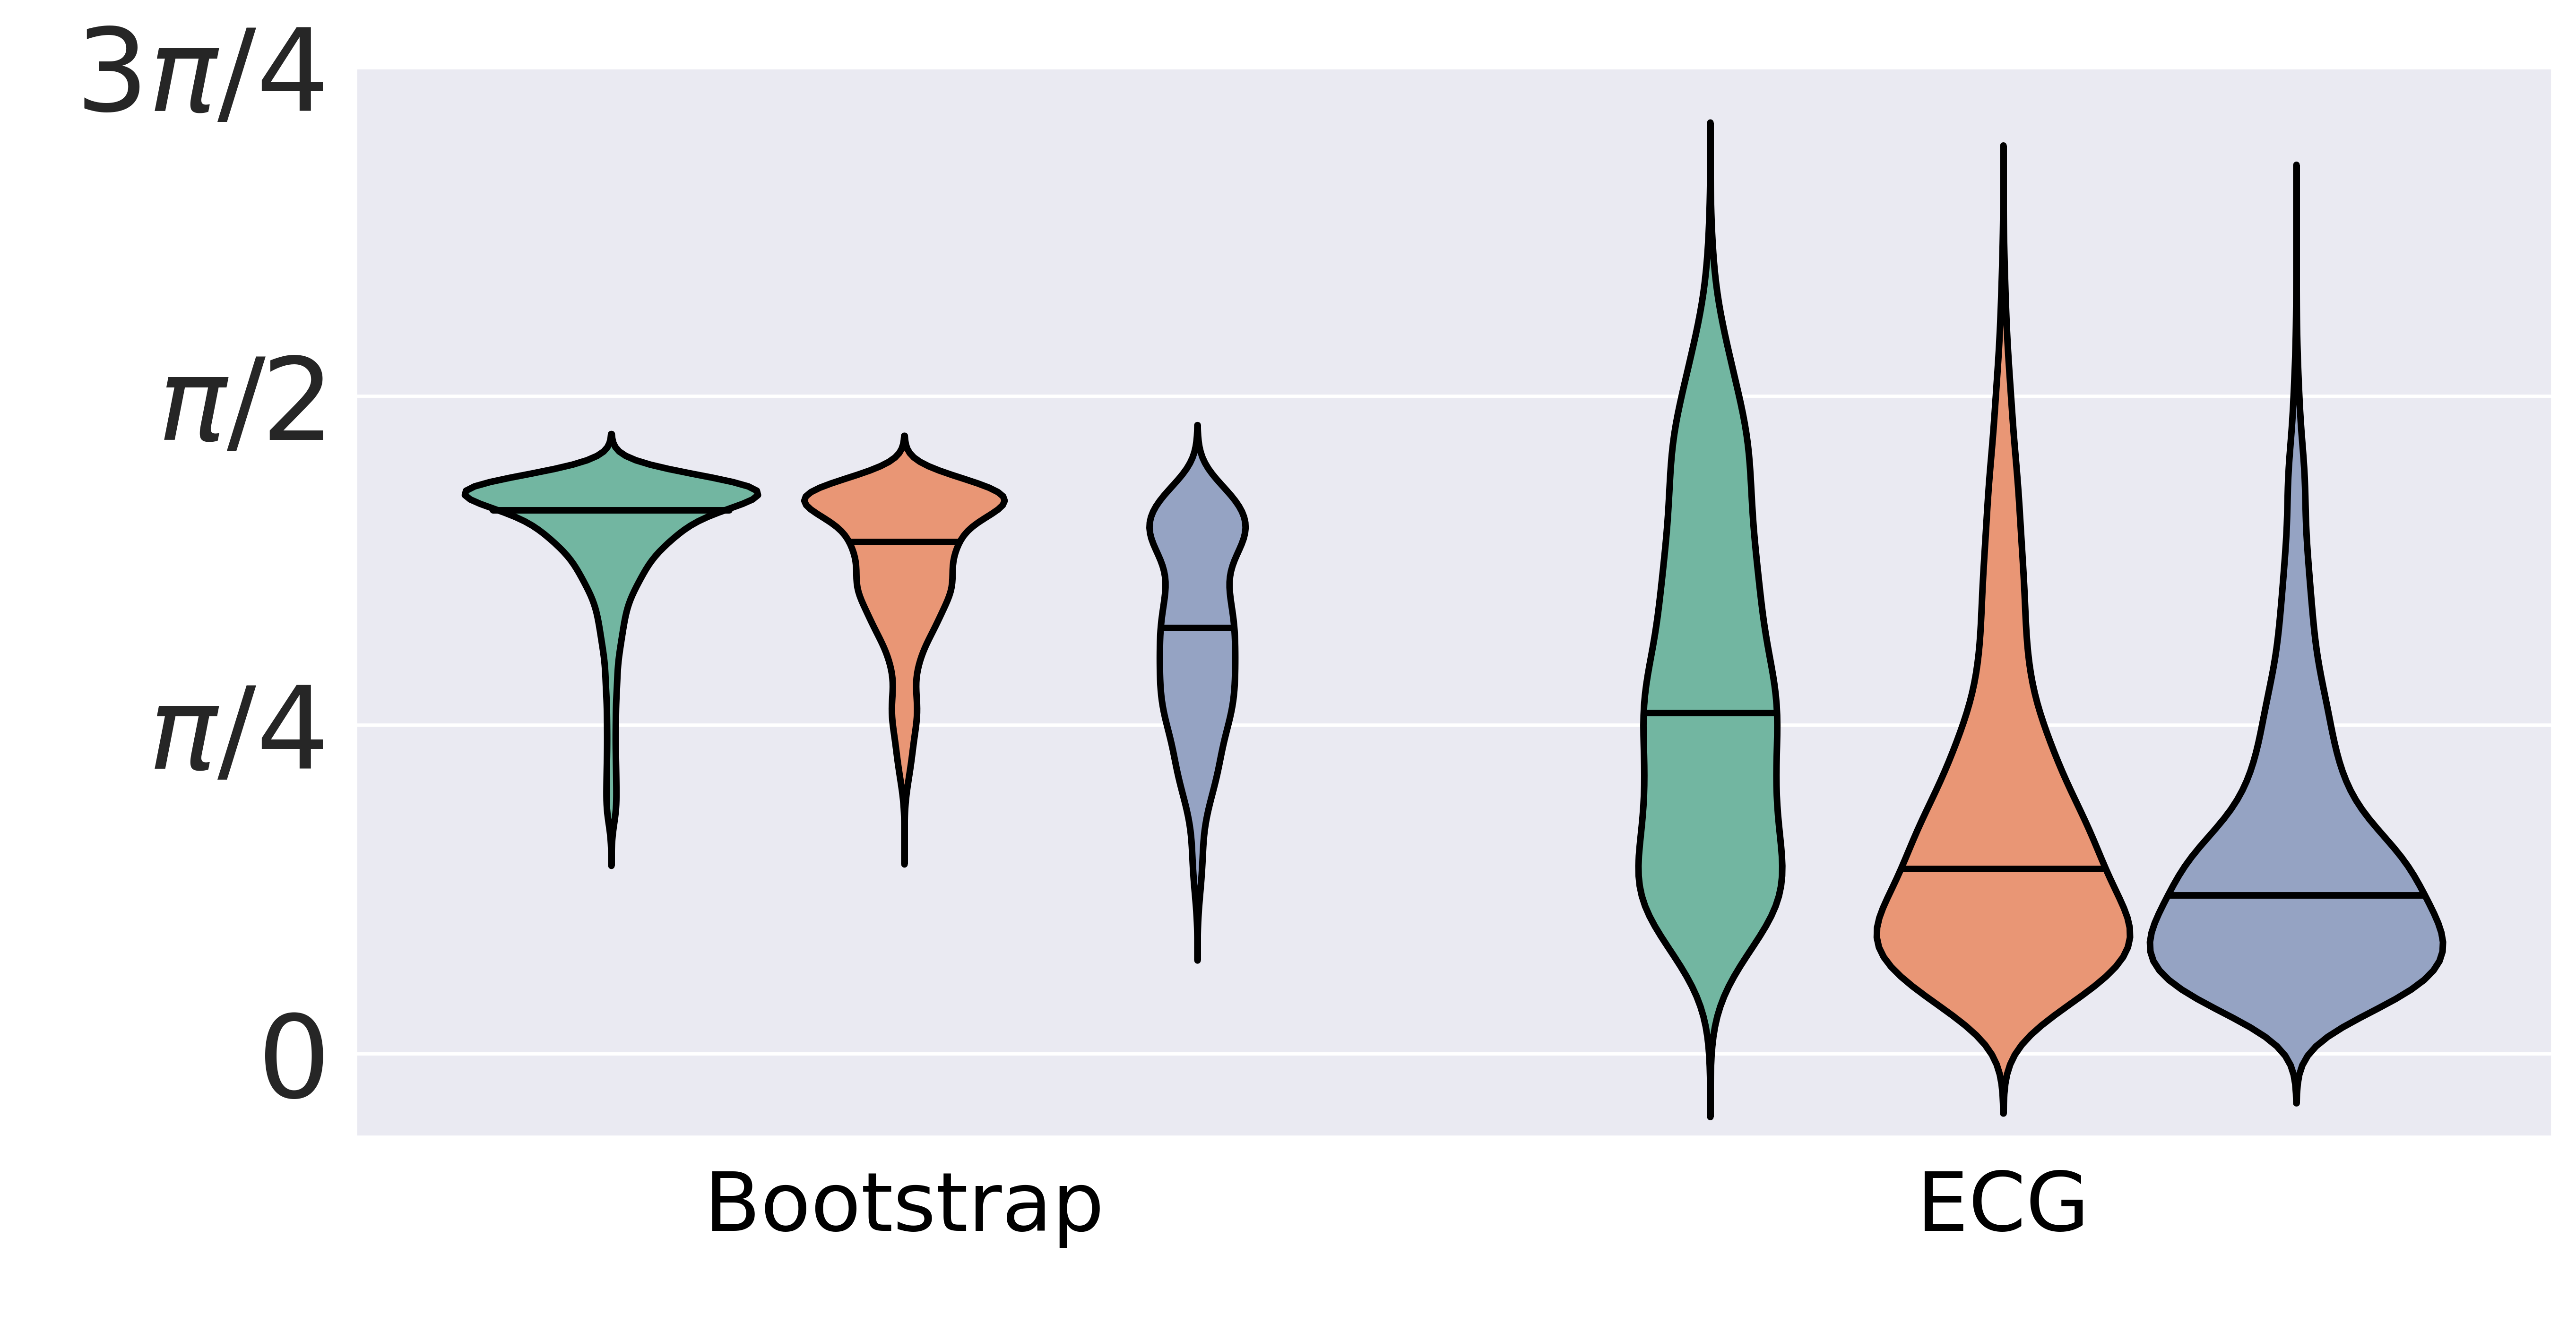

In [11]:

dd = -1
sl = 3


med0 = boostrap_m0[:,:,sl,dd,:].reshape((128*128*10))
med1 = boostrap_m1[:,:,sl,dd,:].reshape((128*128*10))
med2 = boostrap_m2[:,:,sl,dd,:].reshape((128*128*10))

boostrap = np.append(med0,(med1,med2))
motion_b = np.repeat(["M0","M1","M2"],len(med0))
timeA = np.repeat(0,len(boostrap))

med0 =td_m0[:,:,sl,dd,:,:].reshape((128*128*8*10))
med1 = td_m1[:,:,sl,dd,:,:].reshape((128*128*8*10))
med2 = td_m2[:,:,sl,dd,:,:].reshape((128*128*8*10))
td = np.append(med0,(med1,med2))
motion_td = np.repeat(["M0","M1","M2"],len(med0))
timeB = np.repeat(1,len(td))


phs_all = np.append(boostrap,(td))
motion = np.append(motion_b,(motion_td))
time = np.append(timeA, (timeB))

data = pd.DataFrame()
data['phs'] = phs_all
data['motion'] = motion
data['type'] = time


fig, axes = plt.subplots(1, 1, figsize=(12,6),sharex=True,sharey = True,dpi=500)

sns.violinplot(data=data,hue = 'motion',y = 'phs',palette = "Set2", x = 'type',
    ax = axes,linewidth = 4 ,legend = False,linecolor= 'black',inner='quartile',
    split =False,bw=0.2)

for ii in [9,11,12,14,15,17,18,20,21,23,24,26]:
    axes.get_children()[ii].set_alpha(0)
    axes.get_children()[ii].set_linewidth(10)
    axes.get_children()[ii].set_linestyle('-')


axes.set_xticks([0,1])
axes.set_xticklabels(["Bootstrap","ECG"],size = 25,color = 'black')
axes.tick_params(axis='y', which='major', labelsize=35)
axes.set_yticks([0,math.pi/4,math.pi/2,3*math.pi/4,math.pi])
axes.set_yticklabels(['$0$','$\pi/4$','$\pi/2$','$3\pi/4$','$\pi$',],size = 35,rotation = 0)
axes.set_ylim([-0.2,3*math.pi/4])
axes.set_ylabel('radians',color='white')
axes.set_xlabel('radians',color='white')

for ii in range(6):
    axes.get_children()[ii].set_linewidth(2)
    axes.get_children()[ii].set_edgecolor('black')

for ii in [10,13,16,19,22,25]:
    axes.get_children()[ii].set_color('black')
    axes.get_children()[ii].set_linestyle('solid')
    axes.get_children()[ii].set_linewidth(2)


#xes.get_children()[12].set_color('blue')
#sns.pointplot(x = 'motion', y='phs', data=data, estimator=np.mean)
axes.legend([],[], frameon=False)
plt.show()


In [71]:
sns.color_palette("husl",8)[3:5]
colors= sns.color_palette("Set2",3)
c0 = sns.dark_palette(colors[0],n_colors=8)
c1 = sns.dark_palette(colors[1],n_colors=8)
c2 = sns.dark_palette(colors[2],n_colors=8)

#sns.dark_palette(colors[0],n_colors=8)[:4]+(sns.light_palette(colors[0],n_colors=8,reverse=True)[:4])#

/home/ahannum/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ahannum/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


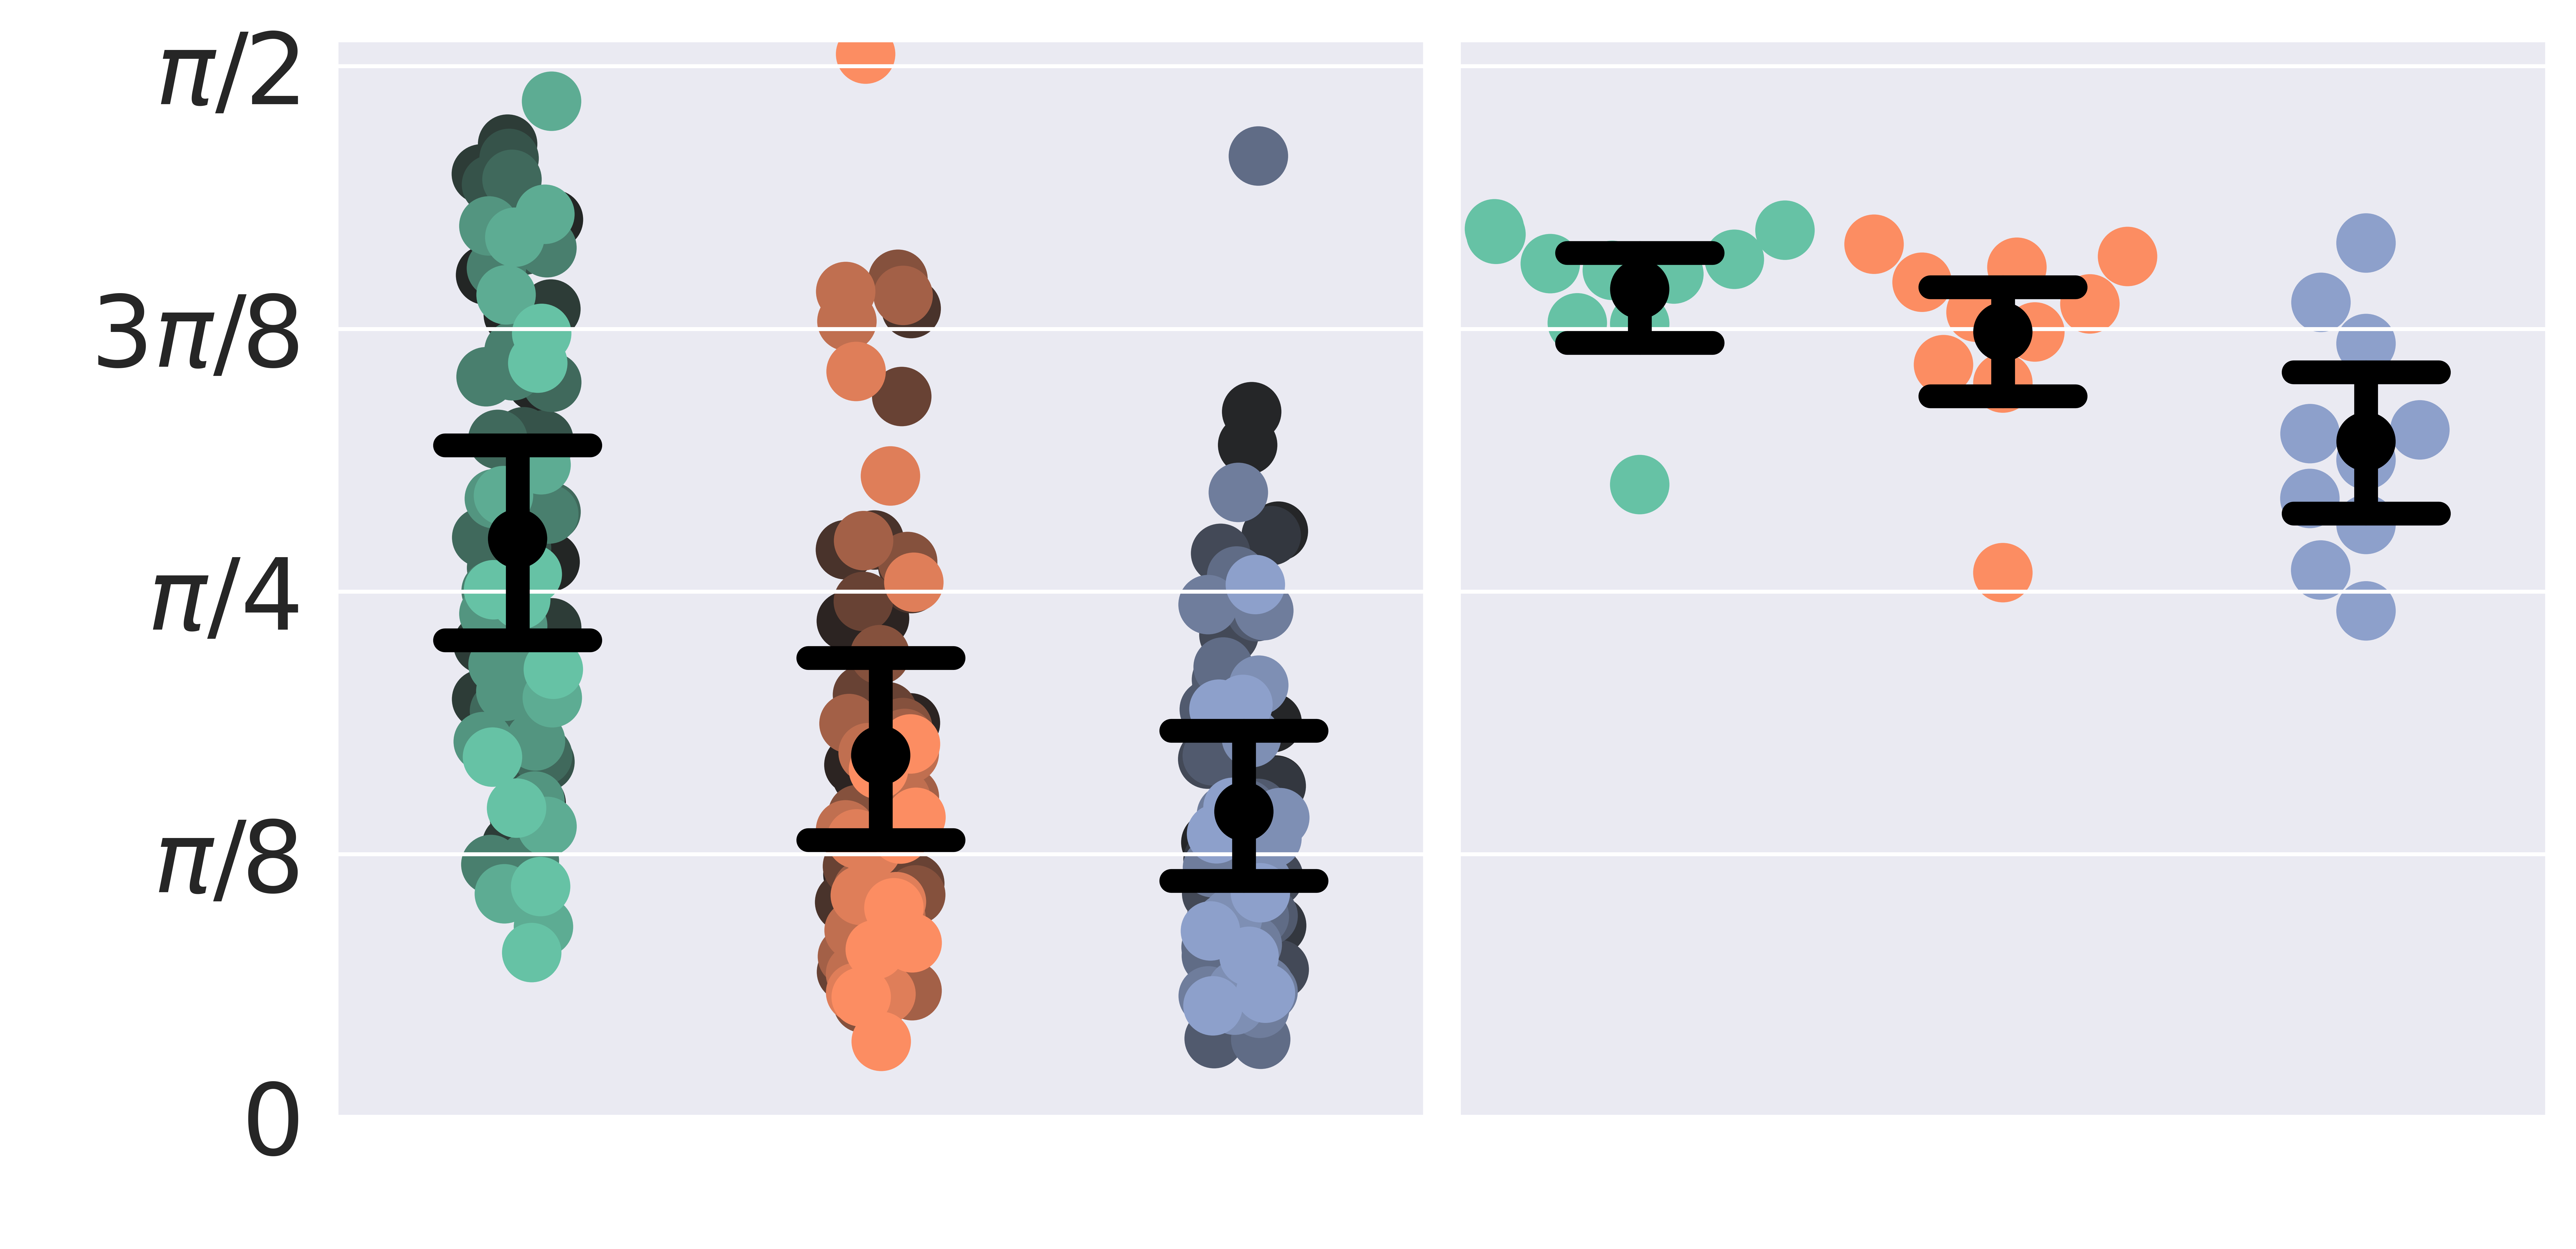

In [83]:

dd = 3
sl = 3

data = pd.DataFrame()
med0 = np.nanmean(boostrap_m0[:,:,sl,dd,:],axis = (0,1))
med1 = np.nanmean(boostrap_m1[:,:,sl,dd,:],axis = (0,1))
med2 = np.nanmean(boostrap_m2[:,:,sl,dd,:],axis = (0,1))

boostrap = np.append(med0,(med1,med2))
motion_b = np.repeat(["M0","M1","M2"],len(med0))
timeA = np.repeat(0,len(boostrap))


phs_all = boostrap
motion = motion_b
time = timeA

data = pd.DataFrame()
data['phs'] = phs_all
data['motion'] = motion
data['type'] = time


fig, axes = plt.subplots(1, 2, figsize=(10,5),sharex=True,sharey = True,dpi=1000)
count = 0
slices = [0,1,2]


for ii in range(2):
    axes[ii].set_xticks([0,1,2])
    axes[ii].set_xticklabels(['1','2','3'],size = 1,color='white')
    axes[ii].tick_params(axis='y', which='major', labelsize=35)
    axes[ii].tick_params(axis='x', which='major', labelsize=35)
    axes[ii].set_yticks([0,math.pi/8,math.pi/4,3*math.pi/8,math.pi/2])
    axes[ii].set_yticklabels(['$0$','$\pi/8$','$\pi/4$','$3\pi/8$','$\pi/2$'],size = 25,rotation = 0)
    axes[ii].set_ylim([0,math.pi/2+0.04])
    axes[ii].set_xlim([-0.2,2.2])
    axes[ii].set_xticks([0,1,2])
    axes[ii].set_xticklabels([0,1,2],size = 1,color = 'white',rotation = 0)
    axes[ii].set_xlabel('',color = 'white')
    axes[ii].set_ylabel('',color = 'white')
            


sns.swarmplot(data=data,x = 'motion',y = 'phs',palette = "Set2", hue = 'motion',legend = None,
    size = 15,zorder = 0,edgecolor='gray', ax = axes[1])


sns.pointplot(
    data=data,color = 'black',errwidth=6,scale = 1.7, 
    y = 'phs', x = 'motion', #errorbar=("se",np.nanstd(data,-1)),
    capsize=.4, join=False, orient ='v',ax=axes[1],
)



# Trigger Delay
for ii in range(8):

    med0 =np.reshape(np.nanmean(td_m0[:,:,sl,dd,ii,:],axis = (0,1,)),10)
    med1 = np.reshape(np.nanmean(td_m1[:,:,sl,dd,ii,:],axis = (0,1,)),10)
    med2 = np.reshape(np.nanmean(td_m2[:,:,sl,dd,ii,:],axis = (0,1,)),10)
    td = np.append(med0,(med1,med2))
    motion_td = np.repeat(["M0","M1","M2"],len(med0))
    timeB = np.repeat(1,len(td))

    phs_all =td
    motion = motion_td
    time = timeB

    
    data = pd.DataFrame()
    data['phs'] = phs_all
    data['motion'] = motion
    data['type'] = time

    color = [c0[ii],c1[ii],c2[ii]]


    sns.stripplot(data=data,x = 'motion',y = 'phs',palette = color, hue = 'motion',legend = None,
    size = 15,zorder = 0,edgecolor='gray',alpha =1,ax = axes[0] )



data = pd.DataFrame()
med0 =np.reshape(np.nanmean(td_m0[:,:,sl,dd,:,:],axis = (0,1,-2)),10)
med1 = np.reshape(np.nanmean(td_m1[:,:,sl,dd,:,:],axis = (0,1,-2)),10)
med2 = np.reshape(np.nanmean(td_m2[:,:,sl,dd,:,:],axis = (0,1,-2)),10)
td = np.append(med0,(med1,med2))
motion_td = np.repeat(["M0","M1","M2"],len(med0))
timeB = np.repeat(1,len(td))

phs_all =td
motion = motion_td
time = timeB


data = pd.DataFrame()
data['phs'] = phs_all
data['motion'] = motion
data['type'] = time




sns.pointplot(
    data=data,color = 'black',errwidth=6,scale = 1.7, 
    y = 'phs', x = 'motion', #errorbar=("se",np.nanstd(data,-1)),
    capsize=.4, join=False, orient ='v',ax=axes[0],
)



plt.subplots_adjust(wspace=0.03, hspace=0.03)   
plt.show()



In [81]:
c2

[(0.1437079419259179, 0.14773671663669272, 0.15873848110683172),
 (0.20148204562634195, 0.21546108328452296, 0.24871588585022708),
 (0.26086098554066667, 0.2850666823392374, 0.34119266294760564),
 (0.31863508924109074, 0.3527910489870676, 0.4311700676910011),
 (0.37801402915541543, 0.422396648041782, 0.5236468447883796),
 (0.4357881328558395, 0.4901210146896122, 0.613624249531775),
 (0.4951670727701642, 0.5597266137443265, 0.7061010266291535),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549)]

In [ ]:
image.png